# Attention as Nadaraya-Watson Kernel Regression

Written by Byung Chun Kim (<wizardbc@gmail.com>)



## Regressions Problem

* Data : $\{x_1,\ldots, x_m\}$
* Labels : $\{y_1,\ldots, y_m\}$

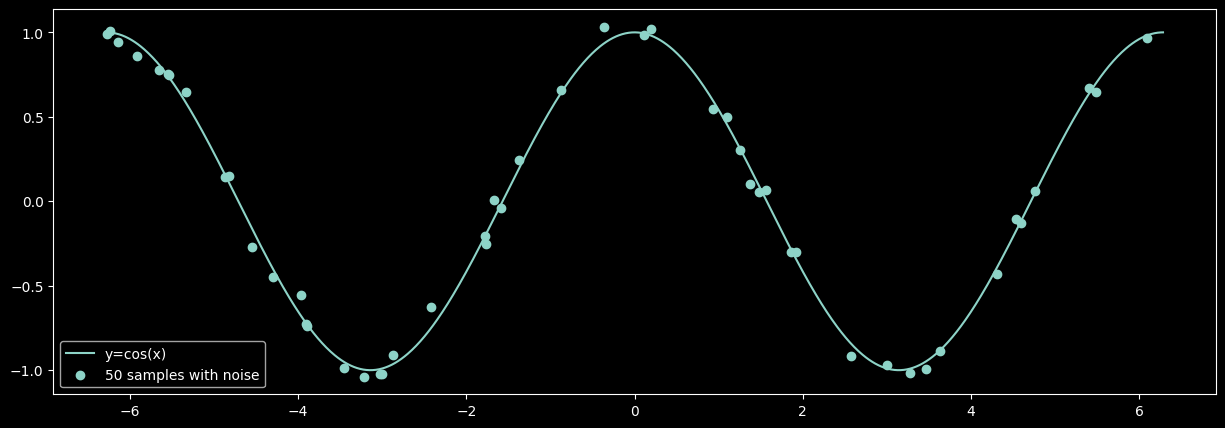

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
plt.style.use('dark_background')

num_samples = 50

x_linsp = torch.linspace(-2*np.pi, 2*np.pi, 1000)
y_true = torch.cos(x_linsp)

torch.manual_seed(1234)
sample_x = x_linsp[torch.randperm(1000)[:num_samples]].sort()[0]
sample_y = torch.cos(sample_x) + torch.randn(num_samples)/20

plt.figure(figsize=(15,5))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples} samples with noise')
plt.legend()
plt.show()

### Linear Regression

Estimator : $$y=wx+b.$$

Find $w$ and $b$ such that minimize MSE : $\frac{1}{m} \sum_{i=1}^{m}\left(y_i - \left(wx_{i} + b\right)\right)^2$.



In [2]:
w = torch.tensor(1, requires_grad=True, dtype=torch.float16)
b = torch.tensor(0, requires_grad=True, dtype=torch.float16)

def forward(x):
  return w*x + b

def mse(y_true, y_pred):
  return ((y_true - y_pred)**2).mean()

In [3]:
lr = 0.0001

for epoch in range(2000):
  output = forward(sample_x)

  loss = mse(sample_y, output)

  if epoch%100 == 0:
    print(epoch, loss.item())

  loss.backward()
  with torch.no_grad():
    w -= lr * w.grad
    b -= lr * b.grad
    w.grad.zero_()
    b.grad.zero_()

0 15.617790222167969
100 8.878774642944336
200 5.2042083740234375
300 3.1660094261169434
400 1.983465552330017
500 1.3273338079452515
600 0.9527637958526611
700 0.7395327091217041
800 0.624051570892334
900 0.5590143799781799
1000 0.5220780968666077
1100 0.5016373991966248
1200 0.4900153875350952
1300 0.48348885774612427
1400 0.47982871532440186
1500 0.47777706384658813
1600 0.4766285717487335
1700 0.47598978877067566
1800 0.47563332319259644
1900 0.4754144549369812


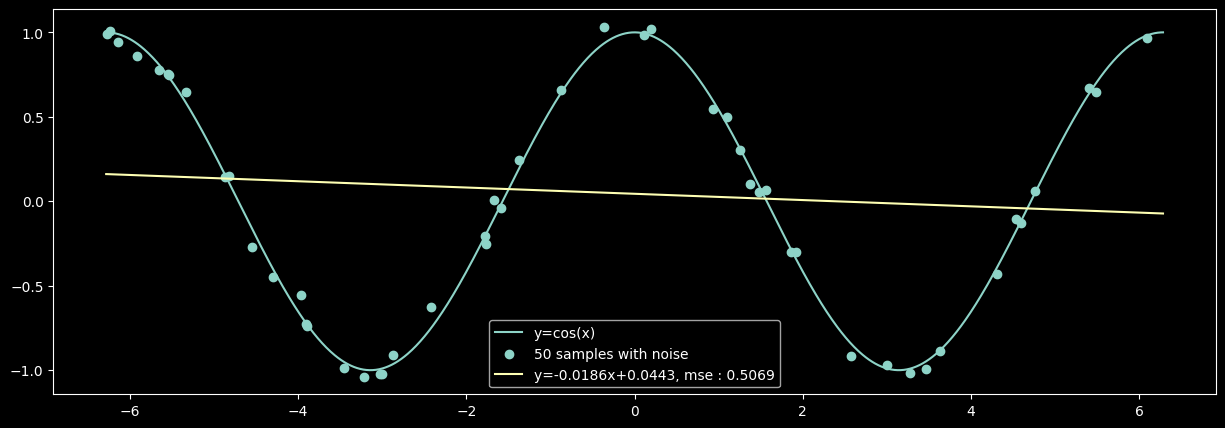

In [4]:
with torch.no_grad():
  y_pred = forward(x_linsp)
  loss = mse(y_true, y_pred)

plt.figure(figsize=(15,5))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples} samples with noise')
plt.plot(x_linsp, y_pred, label=f"y={w.item():.4f}x+{b.item():.4f}, mse : {mse(y_true, y_pred):.4f}")
plt.legend()
plt.show()

### Nadaraya-Watson Kernel Regression (1964)

Estimator : $$y = \sum_{i=1}^m \alpha(x, x_i)y_i.$$

Use given a kernel $K$ to get weights of labels according to location $x$.

Define $$\alpha(x, x_i) = \frac{K(x-x_i)}{\sum_{j=1}^{m} K(x-x_j)}.$$
나눠주는 이유는 0~1까지 값을 주기 위해서

* $x$ : query, 구할값
* $x_i$ : keys ($1 \leq i\leq m$), 시간
* $y_i$ : values ($1 \leq i\leq m$), 타겟값

#### Kernel (Score)

* For each key $x_i$ we correspond Gaussian function : $K(x-x_i)$.
* The value $K(x-x_i)$ tends to the score of $x_i$ at $x$.

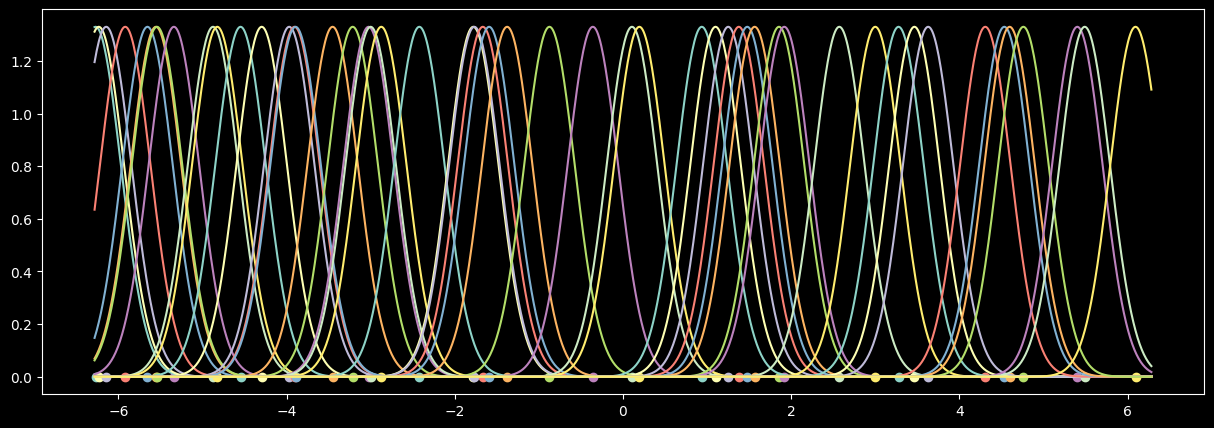

In [5]:
gaussian = lambda x, s=1: torch.exp(torch.distributions.normal.Normal(0,s).log_prob(x))
# triangle = lambda x, h=1: torch.where(torch.abs(x) < h, (h-torch.abs(x))/h**2, torch.zeros(x.shape))

score = lambda x, m: gaussian(x.unsqueeze(-1)-m.unsqueeze(0), .3)
# score = lambda x, m: triangle(x.unsqueeze(-1)-m.unsqueeze(0), 1)

plt.figure(figsize=(15,5))
plt.plot(x_linsp, score(x_linsp, sample_x))
for i in sample_x:
  plt.scatter([i.item()],[0])
plt.show()

#### Weights

* We get weights from the scores.
* Given $x_i$, $$\alpha(x, x_i) = \frac{K(x-x_i)}{\sum_{j=1}^{m} K(x-x_j)}$$ represents the effect of the key $x_i$ to determine the value at $x$.

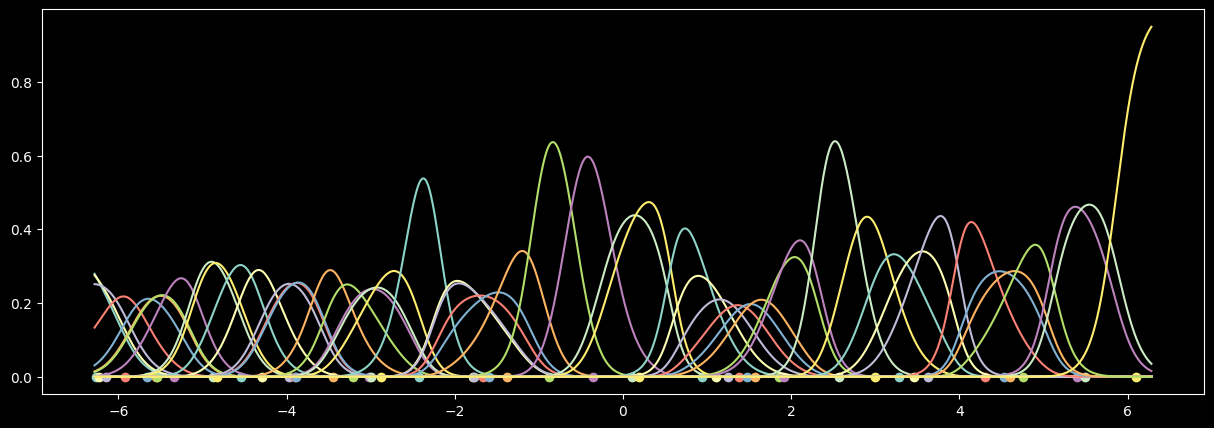

In [6]:
a = score(x_linsp, sample_x)/score(x_linsp, sample_x).sum(1, keepdim=True)
plt.figure(figsize=(15,5))
plt.plot(x_linsp, a)
for i in sample_x:
  plt.scatter([i.item()],[0])
plt.show()

* Finally, determine the value $y$ at $x$ : $$y = \sum_{i=1}^m \alpha(x, x_i)y_i.$$

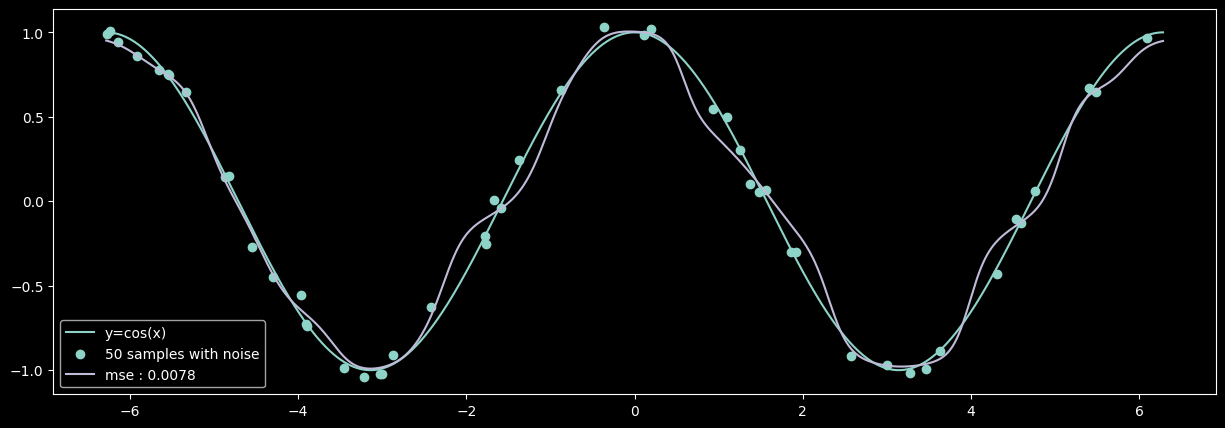

In [7]:
plt.figure(figsize=(15,5))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples} samples with noise')
# plt.plot(x_linsp, y_pred, label=f"y={linear.w.item():.4f}x+{linear.b.item():.4f}, mse : {loss.item():.4f}")
plt.plot([],[])
y_pred = (a*sample_y.unsqueeze(0)).sum(1)
plt.plot(x_linsp, y_pred, label=f"mse : {mse(y_true, y_pred):.4f}")
plt.legend()
plt.show()

* Note that if the keys, the values and the kernel are fixed, then there is no parameter to fit.
-> learn할 만한 것이 없다 결국은 데이터를 나오면 데이터가 나오기 때문에
-> 바꿀 수 있는 파라미터가 없다

## Attention (?)

* Kernel: $K(x-x_i) = \exp(\beta |x-x_i|)$ where $\beta < 0$.
* Weight function: $$\alpha(x, x_i) = \frac{K(x-x_i)}{\sum_{j=1}^{m} K(x-x_j)} = \frac{\exp(\beta |x-x_i|)}{\sum_{j=1}^{m} \exp(\beta |x-x_j|)} = \operatorname{softmax}(\beta |x-x_1|, \beta |x-x_2|, \ldots, \beta |x-x_m|)_i$$

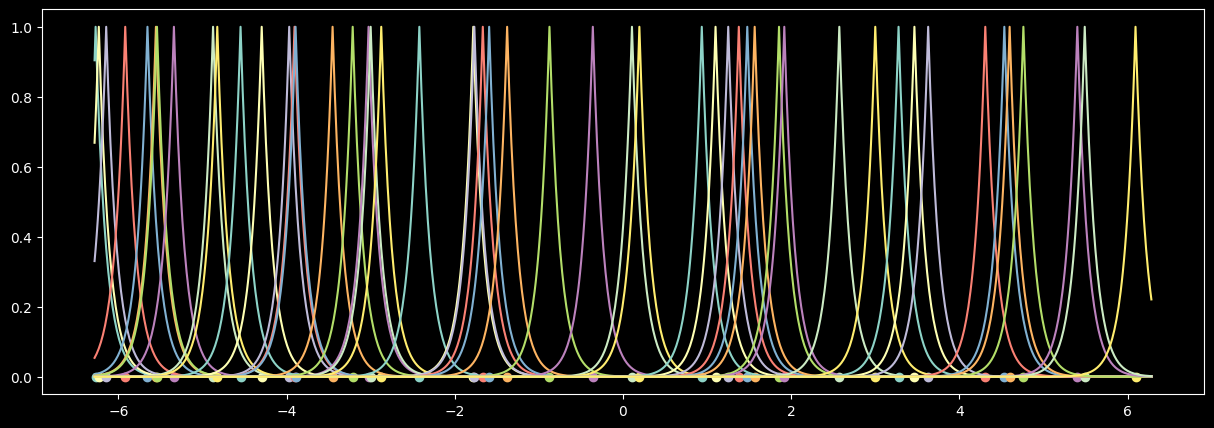

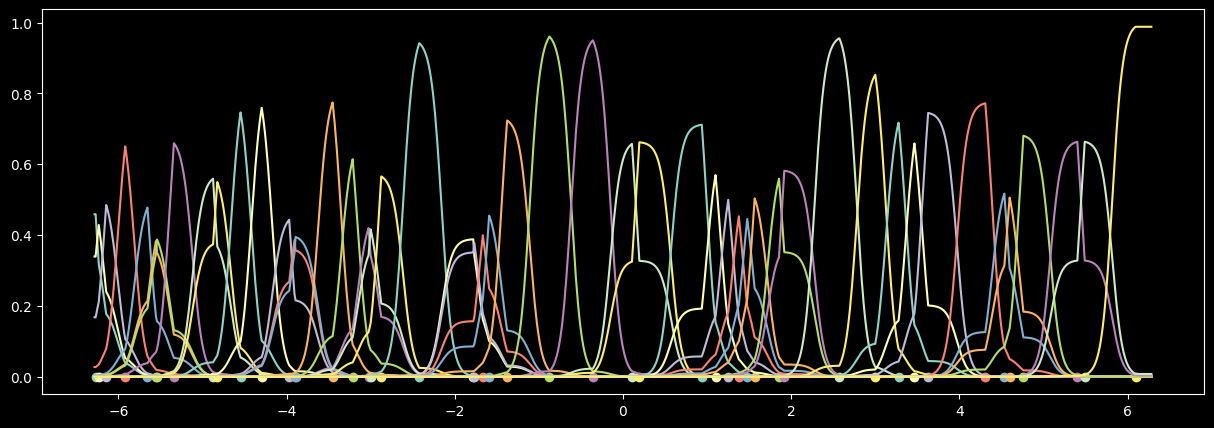

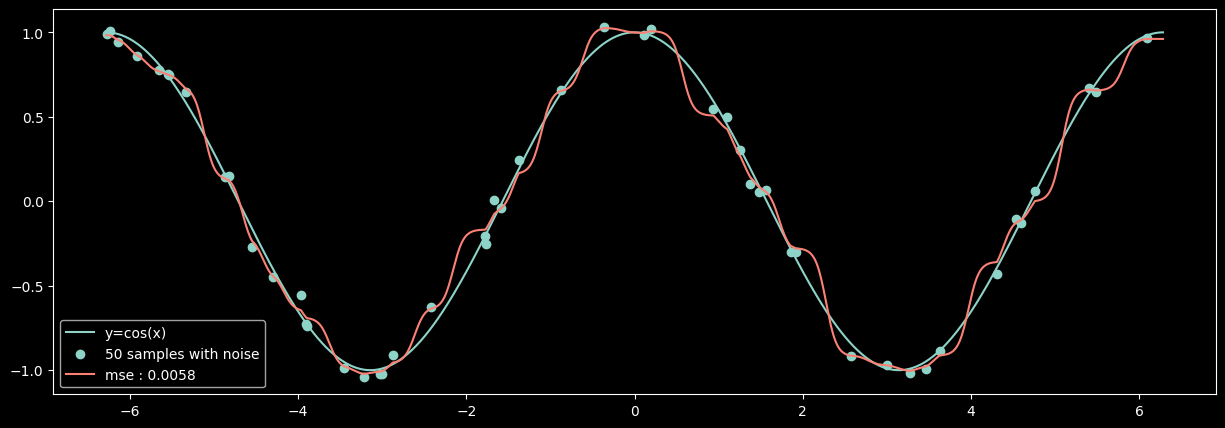

In [8]:
kernel = lambda x, beta=-1: torch.exp(beta*torch.abs(x))

score = lambda x, m: kernel(x.unsqueeze(-1)-m.unsqueeze(0), -8)

plt.figure(figsize=(15,5))
plt.plot(x_linsp, score(x_linsp, sample_x))
for i in sample_x:
  plt.scatter([i.item()],[0])
plt.show()

a = score(x_linsp, sample_x)/score(x_linsp, sample_x).sum(1, keepdim=True)
plt.figure(figsize=(15,5))
plt.plot(x_linsp, a)
for i in sample_x:
  plt.scatter([i.item()],[0])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples} samples with noise')
plt.plot([],[])
plt.plot([],[])
y_pred = (a*sample_y.unsqueeze(0)).sum(1)
plt.plot(x_linsp, y_pred, label=f"mse : {mse(y_true, y_pred):.4f}")
plt.legend()
plt.show()

### MLP

In [9]:
class SimpleMLP(torch.nn.Module):
  def __init__(self, hidden=32):
    super(SimpleMLP, self).__init__()
    self.fc1 = torch.nn.Linear(1, hidden)
    self.fc2 = torch.nn.Linear(hidden, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    return x

mlp = SimpleMLP(32)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)

In [10]:
mlp.train()
for epoch in range(30000):
    output = mlp(sample_x[:,np.newaxis])
    loss = criterion(output, sample_y[:,np.newaxis])
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
      print(epoch, loss.item())
    optimizer.zero_grad()

0 0.5670671463012695
1000 0.36786410212516785
2000 0.2648470997810364
3000 0.17418746650218964
4000 0.1083519458770752
5000 0.06788038462400436
6000 0.04330972209572792
7000 0.028619732707738876
8000 0.01970391720533371
9000 0.014273814857006073
10000 0.011085220612585545
11000 0.009211922064423561
12000 0.007906167767941952
13000 0.006957529578357935
14000 0.006257291417568922
15000 0.005688408389687538
16000 0.005214993841946125
17000 0.004840283188968897
18000 0.004561884328722954
19000 0.004342999309301376
20000 0.0041654990054667
21000 0.0040135933086276054
22000 0.0038564654532819986
23000 0.003684236900880933
24000 0.003550903405994177
25000 0.0034249231684952974
26000 0.003299783216789365
27000 0.003175207646563649
28000 0.0030526190530508757
29000 0.002934098243713379


c:\users\zpdlc\appdata\local\programs\python\python311\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


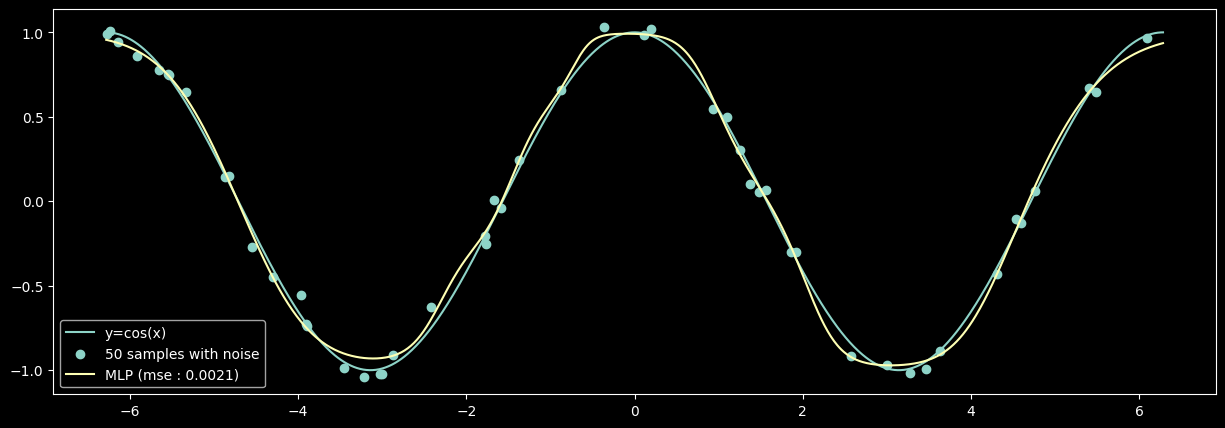

In [11]:
mlp.eval()
with torch.no_grad():
  y_pred = mlp(x_linsp[:,np.newaxis]).flatten()
  loss = criterion(y_pred, y_true[:,np.newaxis])

plt.figure(figsize=(15,5))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples} samples with noise')
plt.plot(x_linsp, y_pred, label=f'MLP (mse : {mse(y_true, y_pred):.4f})')
plt.legend()
plt.show()

## Another Dataset

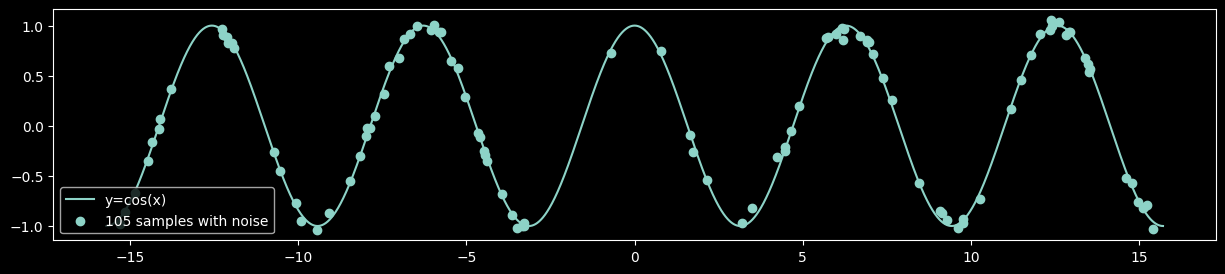

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
plt.style.use('dark_background')

num_samples = 5
num_samples_tail = 50

x_linsp = torch.linspace(-5*np.pi, 5*np.pi, 5000)
y_true = torch.cos(x_linsp)

torch.manual_seed(1234)
sample_idx = torch.cat([torch.randperm(1000)[:num_samples]+2000, torch.randperm(2000)[:num_samples_tail], torch.randperm(2000)[:num_samples_tail] + 3000])
sample_x = x_linsp[sample_idx].sort()[0]
sample_y = torch.cos(sample_x) + torch.randn(num_samples + 2*num_samples_tail)/20

plt.figure(figsize=(15,3))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples + 2*num_samples_tail} samples with noise')
plt.legend()
plt.show()

### Linear

0 91.3231430053711
100 2.785888671875
200 0.5927026867866516
300 0.5383831262588501
400 0.5368109345436096
500 0.5365520119667053
600 0.5363392233848572
700 0.5361248850822449
800 0.5359166264533997
900 0.535706102848053
1000 0.5355008840560913
1100 0.5352997183799744
1200 0.5351030826568604
1300 0.5349112153053284
1400 0.5347238183021545
1500 0.5345421433448792
1600 0.5343639850616455
1700 0.5341906547546387
1800 0.5340219140052795
1900 0.5338577032089233


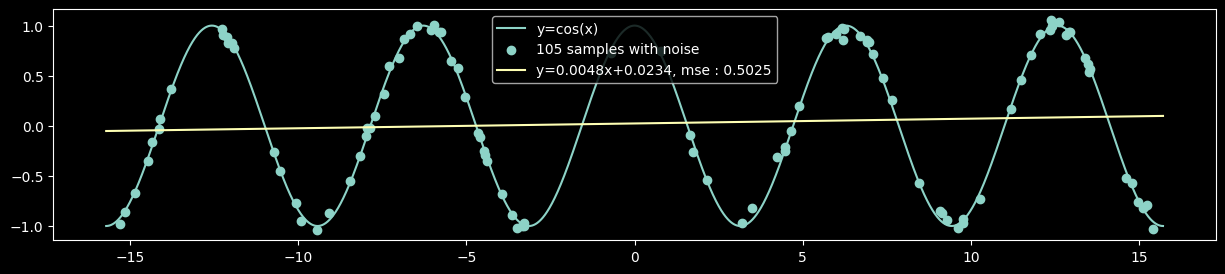

In [13]:
w = torch.tensor(1, requires_grad=True, dtype=torch.float16)
b = torch.tensor(0, requires_grad=True, dtype=torch.float16)

def forward(x):
  return w*x + b

def mse(y_true, y_pred):
  return ((y_true - y_pred)**2).mean()

lr = 0.0001

for epoch in range(2000):
  output = forward(sample_x)

  loss = mse(sample_y, output)

  if epoch%100 == 0:
    print(epoch, loss.item())

  loss.backward()
  with torch.no_grad():
    w -= lr * w.grad
    b -= lr * b.grad
    w.grad.zero_()
    b.grad.zero_()


with torch.no_grad():
  y_pred = forward(x_linsp)
  loss = mse(y_true, y_pred)

plt.figure(figsize=(15,3))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples + 2*num_samples_tail} samples with noise')
plt.plot(x_linsp, y_pred, label=f"y={w.item():.4f}x+{b.item():.4f}, mse : {loss.item():.4f}")
plt.legend()
plt.show()

### Nadaraya-Watson Kernel Regression (1964)

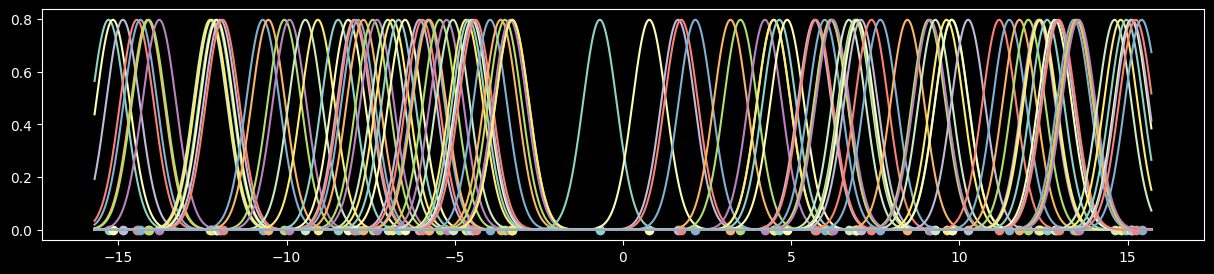

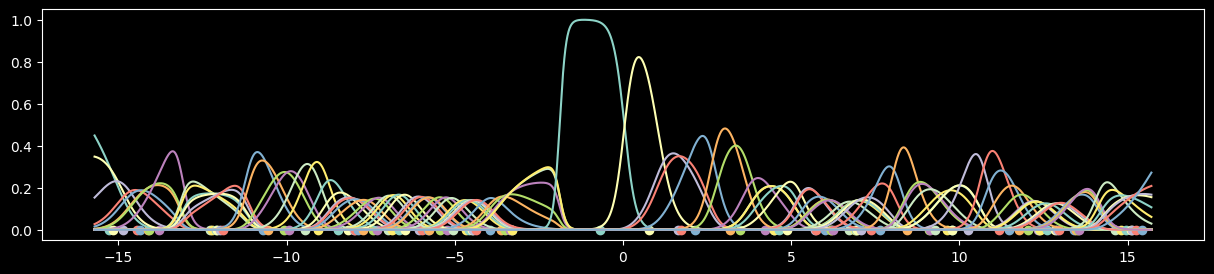

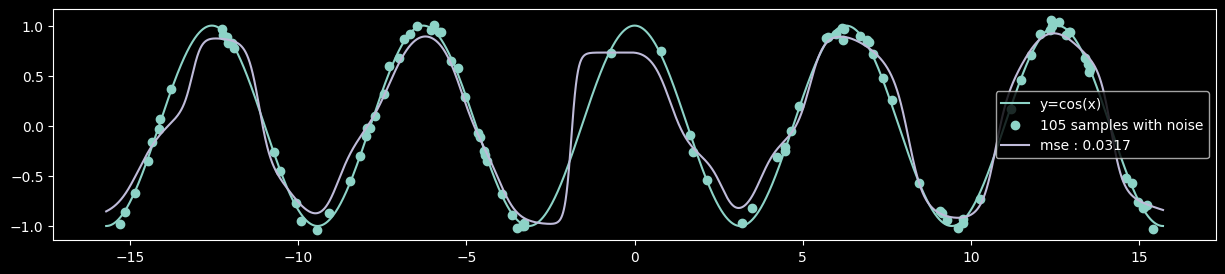

In [14]:
gaussian = lambda x, s=1: torch.exp(torch.distributions.normal.Normal(0,s).log_prob(x))
# triangle = lambda x, h=1: torch.where(torch.abs(x) < h, (h-torch.abs(x))/h**2, torch.zeros(x.shape))

score = lambda x, m: gaussian(x.unsqueeze(-1)-m.unsqueeze(0), .5)
# score = lambda x, m: triangle(x.unsqueeze(-1)-m.unsqueeze(0), 1)

plt.figure(figsize=(15,3))
plt.plot(x_linsp, score(x_linsp, sample_x))
for i in sample_x:
  plt.scatter([i.item()],[0])
plt.show()

a = score(x_linsp, sample_x)/score(x_linsp, sample_x).sum(1, keepdim=True)
plt.figure(figsize=(15,3))
plt.plot(x_linsp, a)
for i in sample_x:
  plt.scatter([i.item()],[0])
plt.show()

plt.figure(figsize=(15,3))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples+2*num_samples_tail} samples with noise')
# plt.plot(x_linsp, y_pred, label=f"y={linear.w.item():.4f}x+{linear.b.item():.4f}, mse : {loss.item():.4f}")
plt.plot([],[])
y_pred2 = (a*sample_y.unsqueeze(0)).sum(1)
plt.plot(x_linsp, y_pred2, label=f"mse : {mse(y_true, y_pred2):.4f}")
plt.legend()
plt.show()

### MLP

0 0.7505549192428589
1000 0.038941722363233566
2000 0.005471380427479744
3000 0.004357472062110901
4000 0.0036607563961297274
5000 0.0032778519671410322
6000 0.0030854425858706236
7000 0.002988462569192052
8000 0.00293442839756608
9000 0.002895279787480831
10000 0.003563221078366041
11000 0.0028407135978341103
12000 0.0031960357446223497
13000 0.002797296503558755
14000 0.0027781075332313776
15000 0.0027625299990177155
16000 0.002748352475464344
17000 0.002753334352746606
18000 0.0027968259528279305
19000 0.0027109161019325256
20000 0.0027000231202691793
21000 0.002713817870244384
22000 0.00273157749325037
23000 0.0026660552248358727
24000 0.002656398108229041
25000 0.0026471144519746304
26000 0.0031269986648112535
27000 0.002677756827324629
28000 0.0026207685004919767
29000 0.0026126429438591003


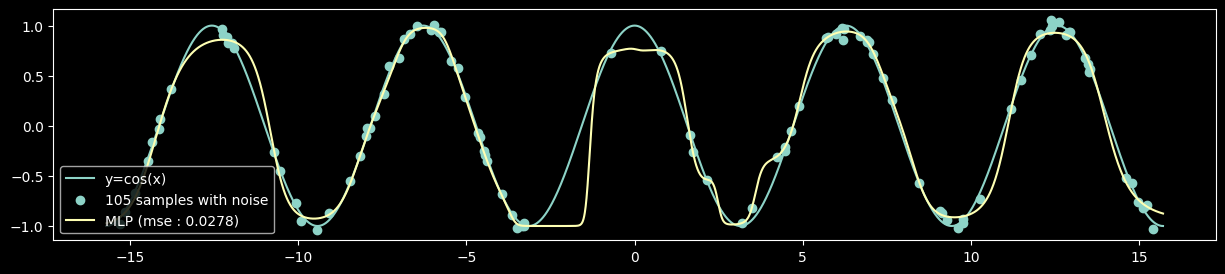

In [15]:
mlp = SimpleMLP(64)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.005)

mlp.train()
for epoch in range(30000):
  output = mlp(sample_x[:,np.newaxis])
  loss = criterion(output, sample_y[:,np.newaxis])
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

mlp.eval()
with torch.no_grad():
  y_pred = mlp(x_linsp[:,np.newaxis])
  loss = criterion(y_pred, y_true[:,np.newaxis])

plt.figure(figsize=(15,3))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples+2*num_samples_tail} samples with noise')
plt.plot(x_linsp, y_pred, label=f'MLP (mse : {loss.item():.4f})')
plt.legend(loc='lower left')
plt.show()

## Attention

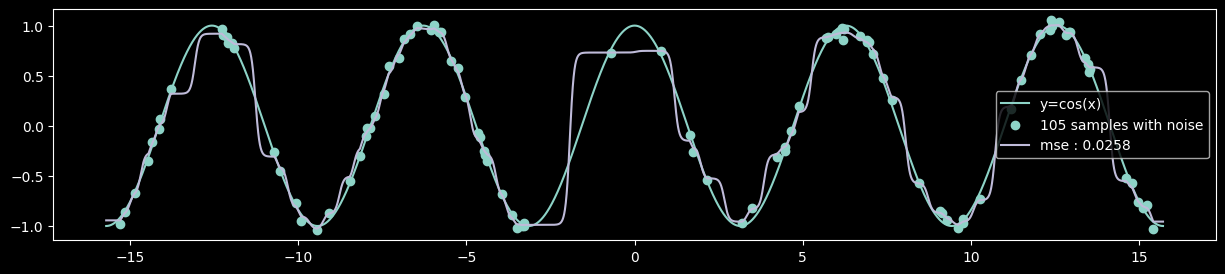

In [16]:
beta=-8
y_pred = torch.matmul(torch.softmax(beta*(torch.abs(x_linsp.unsqueeze(1) - sample_x.unsqueeze(0))), dim=1), sample_y.unsqueeze(1)).flatten()

plt.figure(figsize=(15,3))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples+2*num_samples_tail} samples with noise')
plt.plot([],[])
plt.plot(x_linsp, y_pred, label=f"mse : {mse(y_true, y_pred):.4f}")
plt.legend()
plt.show()

### Multi-Headed Nadaraya-Watson Kernel Regression

* Simplified version of multi-head attention : only have bias terms.

In [17]:
gaussian = lambda x, m=0, s=1: torch.exp(torch.distributions.normal.Normal(m,s).log_prob(x))

class MultiHeadNW(torch.nn.Module):
  def __init__(self, keys, values, heads=6):
    super(MultiHeadNW, self).__init__()
    self.keys = keys.unsqueeze(1)
    self.values = values.unsqueeze(1).unsqueeze(0)

    self.score = lambda x, m: gaussian(x.unsqueeze(1)-m.unsqueeze(0), .3)

    self.heads = heads
    self.lin_q = torch.nn.Linear(1, heads)
    self.lin_k = torch.nn.Linear(1, heads)
    self.lin_v = torch.nn.Linear(1, heads)
    self.lin_o = torch.nn.Linear(heads, 1)

    self.lin_q.weight.data.fill_(1.0)
    self.lin_q.weight.requires_grad_(False)
    self.lin_q.bias.data = torch.linspace(-3*np.pi, 3*np.pi, heads)
    self.lin_k.weight.data.fill_(1.0)
    self.lin_k.weight.requires_grad_(False)
    self.lin_k.bias.data.fill_(0.0)
    self.lin_v.weight.data.fill_(1.0)
    self.lin_v.weight.requires_grad_(False)
    self.lin_v.bias.data.fill_(0.0)

  def forward(self, x):
    x = (self.lin_q(x.unsqueeze(1)))
    k = (self.lin_k(self.keys))
    v = (self.lin_v(self.values))
    a = self.score(x, k)/self.score(x, k).sum(1, keepdim=True)
    p = (a*v).sum(1)
    p = self.lin_o(p).squeeze()
    return p

In [18]:
multi_head = MultiHeadNW(sample_x, sample_y, heads=16)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(multi_head.parameters(), lr=0.001)

In [19]:
multi_head.train()

for epoch in range(2000):
  output = multi_head(sample_x)
  loss = criterion(output, sample_y)
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

0 0.40952566266059875
100 0.08451519161462784
200 0.03045758605003357
300 0.02156429924070835
400 0.018265483900904655
500 0.016008757054805756
600 0.01412799209356308
700 0.012534292414784431
800 0.011228080838918686
900 0.010204223915934563
1000 0.009431243874132633
1100 0.00885178055614233
1200 0.008393006399273872
1300 0.00798191037029028
1400 0.007565666455775499
1500 0.007134297862648964
1600 0.006724110804498196
1700 0.00638934038579464
1800 0.00615558959543705
1900 0.006008615717291832


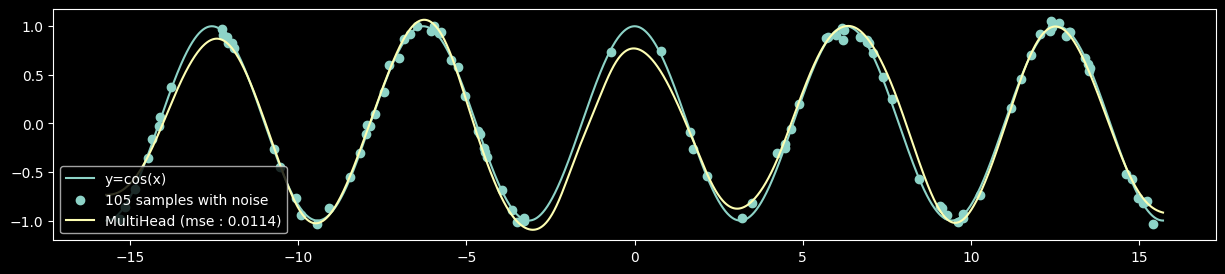

In [20]:
multi_head.eval()
with torch.no_grad():
  y_pred = multi_head(x_linsp)
  loss = criterion(y_pred, y_true)

plt.figure(figsize=(15,3))
plt.plot(x_linsp, y_true, label='y=cos(x)')
plt.scatter(sample_x, sample_y, label=f'{num_samples+2*num_samples_tail} samples with noise')
plt.plot(x_linsp, y_pred, label=f'MultiHead (mse : {loss.item():.4f})')
plt.legend()
plt.show()

In [21]:
q = [p for p in multi_head.lin_q.parameters()][1]
k = [p for p in multi_head.lin_k.parameters()][1]
v = [p for p in multi_head.lin_v.parameters()][1]

q, k, v

(Parameter containing:
 tensor([-10.3856,  -8.3742,  -6.9867,  -5.6410,  -4.4303,  -3.1801,  -2.0780,
          -0.4262,   0.7325,   1.4102,   3.0660,   4.2016,   5.2674,   6.3041,
           8.3245,   9.2523], requires_grad=True),
 Parameter containing:
 tensor([ 0.9608,  0.2060,  0.0752, -0.0138,  0.0320,  0.0385,  0.1931, -0.2021,
         -0.1042,  0.4748,  0.0756,  0.1967,  0.3875,  0.6074, -0.1564,  0.1725],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0377, -0.0369,  0.0379, -0.0375, -0.0304,  0.0373,  0.0372, -0.0377,
          0.0356, -0.0445, -0.0327,  0.0385,  0.0376, -0.0352,  0.0331,  0.0104],
        requires_grad=True))